In [94]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from IPython.display import clear_output
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric import nn as gnn
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style(style="whitegrid")

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [10]:
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe


DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["AVAXUSDT"]
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH
EPS = np.finfo(float).eps
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'
TODAY = datetime.now().strftime('%Y-%m-%d')

In [11]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [16]:
symbols = ds.fetch_future_symbols()
symbols = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [14]:
raw_df_filename = f'ohlcv_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{TODAY}.csv'

In [17]:
data = []
for symbol in symbols:
    try:
        for ohlcv in ds.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)
symbols_df.to_csv(raw_df_filename, index=False)

In [18]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [19]:
symbols_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume
0,AVAXUSDT,2024-03-24 19:00:00,53.785000,53.919998,53.685001,53.805000,13990.400391
1,AVAXUSDT,2024-03-24 19:15:00,53.805000,54.000000,53.735001,53.945000,14729.599609
2,AVAXUSDT,2024-03-24 19:30:00,53.945000,54.025002,53.810001,53.930000,15571.400391
3,AVAXUSDT,2024-03-24 19:45:00,53.930000,54.000000,53.814999,53.869999,7692.899902
4,AVAXUSDT,2024-03-24 20:00:00,53.869999,54.200001,53.665001,54.154999,35579.300781


In [82]:
def fe(df):
    df = df.copy()
    # label
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['sqr_log_return'] = df['log_return'] ** 2
    # features
    df['open2close'] = df['Open'] / df['Close']
    df['low2high'] = df['Low'] / df['High']
    df['tr'] = np.maximum(
        df['High'] - df['Low'], 
        np.maximum(
            np.abs(df['High'] - df['Close'].shift(1)),
            np.abs(df['Low'] - df['Close'].shift(1))
        )
    )

    df['csize'] = df['High'] - df['Low']

    lcsize = df['csize'].max()

    df['nsize_1'] = df['csize'].shift(1) / lcsize
    df['nsize_2'] = df['csize'].shift(2) / lcsize
    df['nsize_3'] = df['csize'].shift(3) / lcsize

    df['rsize_2_1'] = df['nsize_2'] / df['nsize_1']
    df['rsize_3_1'] = df['nsize_3'] / df['nsize_1']
    df['rsize_3_2'] = df['nsize_3'] / df['nsize_2']

    df['gap_1_2'] = df['Open'].shift(1) - df['Close'].shift(1)
    df['gap_1_3'] = df['Open'].shift(2) - df['Close'].shift(1)
    df['gap_2_3'] = df['Open'].shift(2) - df['Close'].shift(2)

    df['rbody'] = (df['Close'] - df['Open']).abs()

    df['rbody_1_2'] = df['rbody'].shift(1) - df['rbody']
    df['rbody_1_3'] = df['rbody'].shift(2) - df['rbody']
    df['rbody_2_3'] = df['rbody'].shift(2) - df['rbody'].shift(1)

    df['slope_low_1_2'] = (df['Low'].shift(1) - df['Low']) / (df['Timestamp'].shift(1) - df['Timestamp']).dt.total_seconds()
    df['slope_high_1_2'] = (df['High'].shift(1) - df['High']) / (df['Timestamp'].shift(1) - df['Timestamp']).dt.total_seconds()
    df['slope_low_1_3'] = (df['Low'].shift(2) - df['Low']) / (df['Timestamp'].shift(2) - df['Timestamp']).dt.total_seconds()
    df['slope_High_1_3'] = (df['High'].shift(2) - df['High']) / (df['Timestamp'].shift(2) - df['Timestamp']).dt.total_seconds()

    max_real_body = df['rbody'].max()

    df['nrbody_1'] = df['rbody'] / max_real_body
    df['nrbody_2'] = df['rbody'].shift(1) / max_real_body
    df['nrbody_3'] = df['rbody'].shift(2) / max_real_body

    df['nrbody_1_total'] = df['rbody'] / df['csize']
    df['nrbody_2_total'] = df['rbody'].shift(1) / df['csize'].shift(1)
    df['nrbody_3_total'] = df['rbody'].shift(2) / df['csize'].shift(2)

    df.dropna(subset=['log_return', 'sqr_log_return', 'nsize_2', 'nsize_3'], inplace=True)

    return df

In [95]:
df_fe = fe(symbols_df)

X = df_fe[
    [
        'open2close', 'low2high', 'tr',
        'nsize_1', 'nsize_2', 'nsize_3',
        'rsize_2_1', 'rsize_3_1', 'rsize_3_2',
        'gap_1_2', 'gap_1_3', 'gap_2_3',
        'rbody_1_2', 'rbody_1_3', 'rbody_2_3',
        'slope_low_1_2', 'slope_high_1_2', 'slope_low_1_3', 'slope_High_1_3',
        'nrbody_1', 'nrbody_2', 'nrbody_3',
        'nrbody_1_total', 'nrbody_2_total', 'nrbody_3_total',


    ]
]
y = df_fe['sqr_log_return']

In [96]:
X.head()

,open2close,low2high,tr,nsize_1,nsize_2,nsize_3,rsize_2_1,rsize_3_1,rsize_3_2,gap_1_2,...,slope_low_1_2,slope_high_1_2,slope_low_1_3,slope_High_1_3,nrbody_1,nrbody_2,nrbody_3,nrbody_1_total,nrbody_2_total,nrbody_3_total
3,1.001114,0.996574,0.185001,0.027494,0.033887,0.030051,1.232554,1.093008,0.886782,0.014999,...,0.000006,-0.000028,0.000044,-0.000000,0.015464,0.003866,0.036082,0.324329,0.069765,0.528301
4,0.994737,0.990129,0.535000,0.023657,0.027494,0.033887,1.162154,1.432418,1.232554,0.060001,...,-0.000167,0.000222,-0.000081,0.000097,0.073454,0.015464,0.003866,0.532710,0.324329,0.069765
5,0.990942,0.990852,0.500000,0.068414,0.023657,0.027494,0.345797,0.401870,1.162154,-0.285000,...,0.000544,0.000506,0.000189,0.000364,0.127578,0.073454,0.015464,0.990005,0.532710,0.324329
6,0.998995,0.994793,0.285000,0.063939,0.068414,0.023657,1.070000,0.370003,0.345797,-0.495003,...,0.000322,0.000083,0.000433,0.000294,0.014175,0.127578,0.073454,0.192984,0.990005,0.532710
7,1.000183,0.994525,0.299999,0.036445,0.063939,0.068414,1.754387,1.877193,1.070000,-0.055000,...,0.000050,0.000067,0.000186,0.000075,0.002578,0.014175,0.127578,0.033341,0.192984,0.990005


In [85]:
y.head()

3    1.239213e-06
4    2.784211e-05
5    8.279126e-05
6    1.011752e-06
7    3.344647e-08
Name: sqr_log_return, dtype: float32

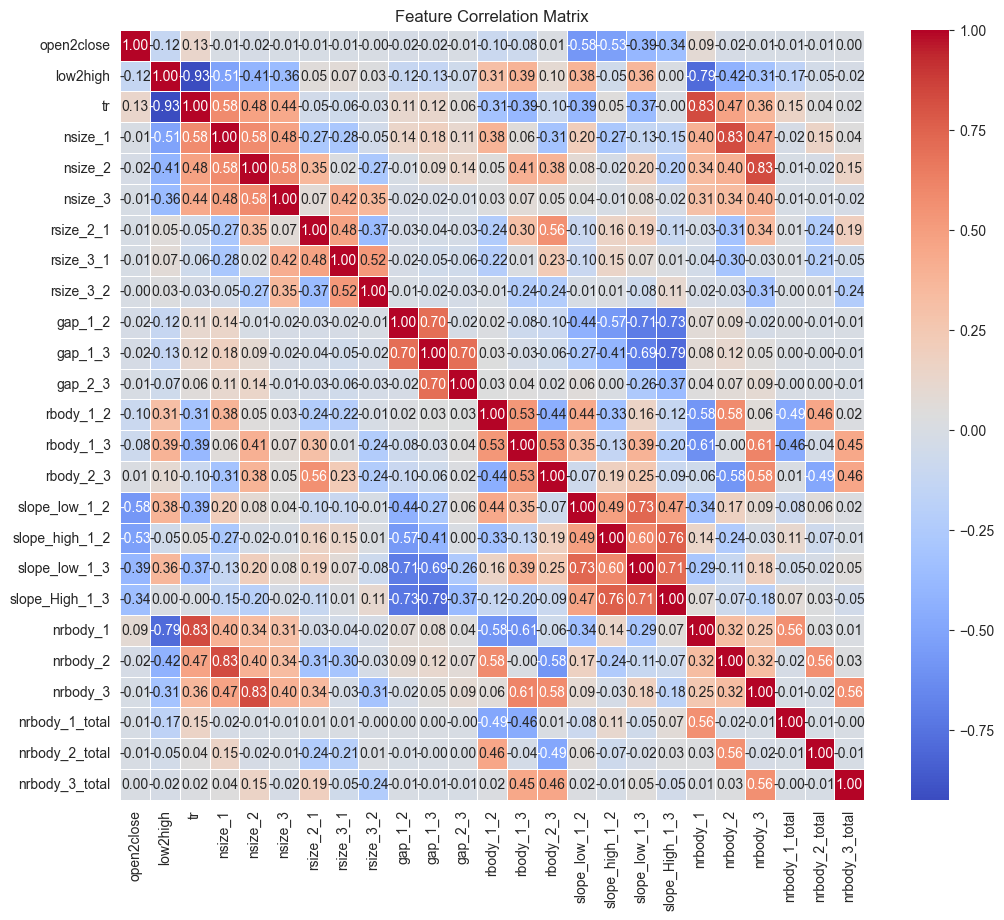

In [86]:
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [101]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=seed)

scaler = StandardScaler()
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)

kf = KFold(n_splits=5, shuffle=False)

fold_mse = []
fold_r2 = []

for train_index, test_index in kf.split(X_train):
    X_tr, X_tst = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_tst = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_train_scaled = scaler.fit_transform(X_tr)
    X_test_scaled = scaler.transform(X_tst)
    
    rf_model.fit(X_train_scaled, y_tr)
    
    y_pred = rf_model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_tst, y_pred)
    r2 = r2_score(y_tst, y_pred)

    fold_mse.append(mse)
    fold_r2.append(r2)
    
    print(f"Fold MSE: {mse:.6f}, Fold R2: {r2:.4f}")

print(f"\nAverage MSE across folds: {np.mean(fold_mse):.6f}")
print(f"Average R2 across folds: {np.mean(fold_r2):.4f}")


Fold MSE: 0.000000, Fold R2: 0.6654
Fold MSE: 0.000000, Fold R2: 0.6483
Fold MSE: 0.000000, Fold R2: 0.8938
Fold MSE: 0.000000, Fold R2: 0.8622
Fold MSE: 0.000000, Fold R2: 0.9888

Average MSE across folds: 0.000000
Average R2 across folds: 0.8117


In [102]:
rf_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
})

rf_imp = rf_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

rf_imp.head(10)

,feature,importance
0,open2close,0.266497
1,low2high,0.259188
2,nrbody_1,0.229476
3,rbody_1_3,0.066553
4,tr,0.034449
5,rbody_1_2,0.031114
6,slope_low_1_2,0.023068
7,nrbody_1_total,0.017550
8,nsize_3,0.011867
9,nsize_2,0.007676


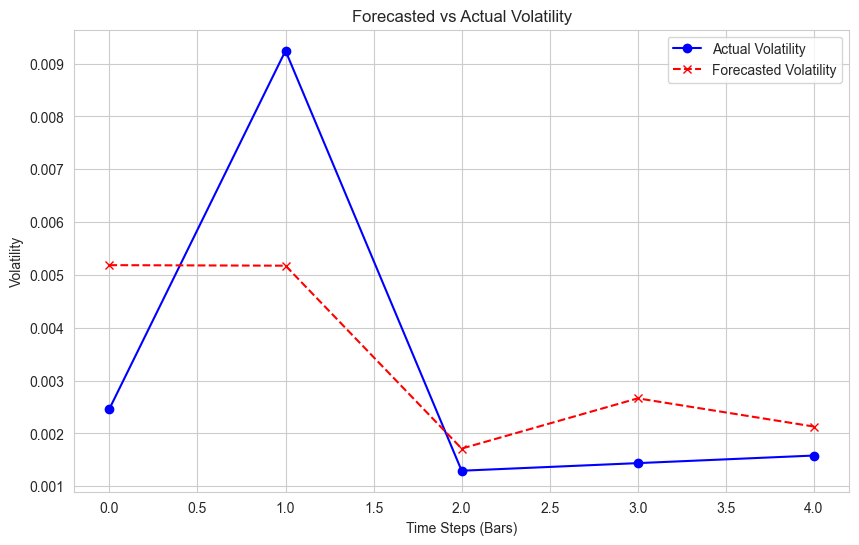

Mean Squared Error (MSE) for Volatility: 0.000005
R-squared (R2) for Volatility: 0.441353


In [103]:
forecast_steps = 5

last_data_point = X_test.iloc[-1].values.reshape(1, -1)

forecasted_squared_volatility = []

for i in range(forecast_steps):
    forecast = rf_model.predict(last_data_point)
    
    forecasted_squared_volatility.append(forecast[0])
    
    last_data_point = np.roll(last_data_point, shift=-1, axis=1)
    last_data_point[0, -1] = forecast[0]

forecasted_volatility = np.sqrt(forecasted_squared_volatility)
actual_squared_volatility = y_test.iloc[-forecast_steps:].values

actual_volatility = np.sqrt(actual_squared_volatility)

plt.figure(figsize=(10, 6))

plt.plot(range(forecast_steps), actual_volatility, label='Actual Volatility', color='blue', marker='o')
plt.plot(range(forecast_steps), forecasted_volatility, label='Forecasted Volatility', color='red', linestyle='--', marker='x')

plt.title('Forecasted vs Actual Volatility')
plt.xlabel('Time Steps (Bars)')
plt.ylabel('Volatility')
plt.legend()

plt.show()

mse_volatility = mean_squared_error(actual_volatility, forecasted_volatility)
r2_volatility = r2_score(actual_volatility, forecasted_volatility)

print(f'Mean Squared Error (MSE) for Volatility: {mse_volatility:.6f}')
print(f'R-squared (R2) for Volatility: {r2_volatility:.6f}')
